# DBSCAN Clustering

This note introduces the **DBSCAN** clustering algorithm using `scikit-learn`, explains the step-by-step logic behind how it works, and then demonstrates a from-scratch implementation to show that the core idea is simple and powerful.

## What is DBSCAN?

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise)** is a clustering algorithm that groups together points that are **closely packed** together — points in **dense regions** form clusters, while points in **sparse regions** are treated as **noise or outliers**.

Unlike K-Means, DBSCAN does **not require you to choose the number of clusters** in advance. Instead, it discovers clusters based on the **density** of data points.

It works by:
1. Picking a point and checking how many neighbors are within a certain distance (`eps`)
2. If there are enough points (`min_samples`), a cluster is formed
3. It then expands the cluster by including nearby density-connected points
4. Points that don't meet the density requirement are labeled as noise

This notebook will:
- Use `scikit-learn` to show how DBSCAN works in practice  
- Explain the intuition and steps in a beginner-friendly way  
- Implement DBSCAN from scratch to understand how density-based clustering works

## Preparation

Let's import the required libraries and create some data.

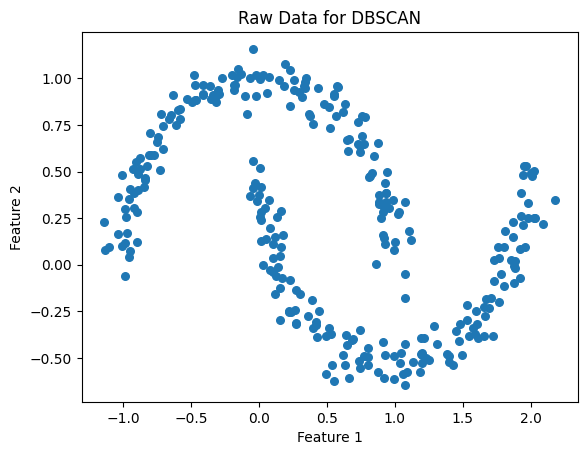

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate non-convex synthetic data (good for DBSCAN)
X, y_true = make_moons(n_samples=300, noise=0.07, random_state=0)

# Visualize raw data
plt.scatter(X[:, 0], X[:, 1], s=30)
plt.title("Raw Data for DBSCAN")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

Here we can see the data. Let's use scikit-learn to cluster it.

## Implement with Scikit-Learn

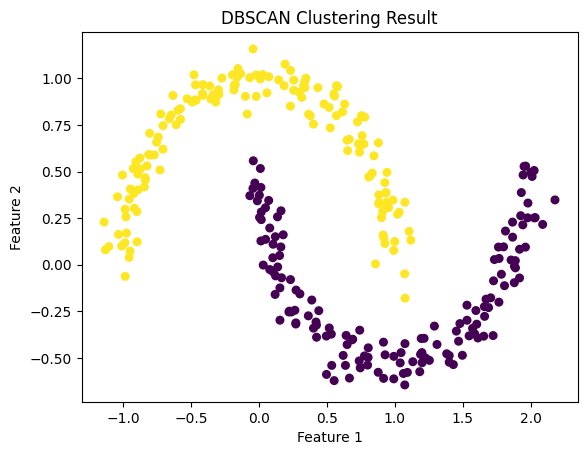

In [ ]:
from sklearn.cluster import DBSCAN

# Create DBSCAN model
dbscan = DBSCAN(eps=0.2, min_samples=5)
dbscan.fit(X)

# Cluster labels assigned by DBSCAN
y_dbscan = dbscan.labels_

# Visualize clusters (noise points are labeled as -1)
plt.scatter(X[:, 0], X[:, 1], c=y_dbscan, s=30, cmap='viridis')
plt.title("DBSCAN Clustering Result")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

## Understanding the Visualization

Each color area shows how the computer "thinks" the data is grouped into clusters.

Instead of using centroids, **DBSCAN forms clusters by connecting nearby points**.  
It starts from a dense region and expands outward by following points that are close enough and have enough neighbors.

Points in dense areas are grouped together, while points in sparse areas are labeled as **noise** (outliers).

Dots are the data points, and each color represents a different cluster.  
Points labeled `-1` (usually shown in black) are considered noise and are **not part of any cluster**.

## Behind the Scenes

### 1. Choose Parameters
- `eps`: How close two points need to be to be considered neighbors  
- `min_samples`: Minimum number of points needed to form a dense region (a core point)

### 2. For Each Point:
#### a. Count Neighbors
- Check how many points are within `eps` distance from the current point.

#### b. Core, Border, or Noise?
- If the point has at least `min_samples` neighbors → it's a **core point**.
- If it's close to a core point but doesn't meet `min_samples` → it's a **border point**.
- If it's not close to any core point → it's labeled as **noise**.

### 3. Expand Clusters
- From each core point, recursively add all density-connected points.
- A cluster grows outward as long as new core points are found in its neighborhood.

### 4. Done
- Once all points are processed, each is either in a cluster or marked as noise.
- No need to specify the number of clusters — DBSCAN finds them automatically based on density.

## Distance Formula (Euclidean)

To decide if points are neighbors, we use **Euclidean distance**:

$$
\text{distance}(x, x') = \sqrt{(x_1 - x_1')^2 + \cdots + (x_n - x_n')^2}
$$

**Where:**

- $x$ and $x'$ are two data points  
- $x_1, x_2, \ldots, x_n$ are feature values of the first point  
- $x_1', x_2', \ldots, x_n'$ are feature values of the second point

> This distance check is handled automatically by `scikit-learn`.

## Let’s Code It

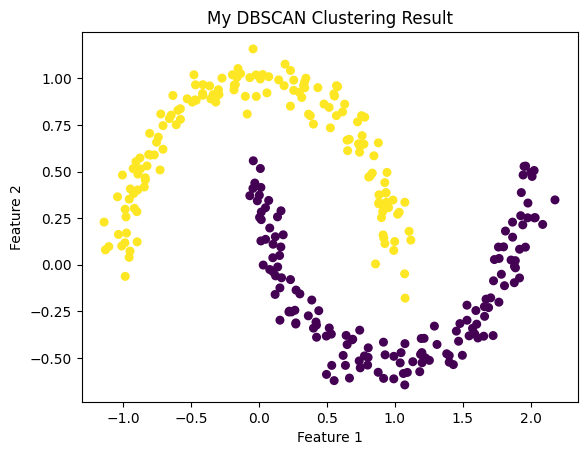

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MyDBSCAN:
    def __init__(self, eps=0.2, min_samples=5):
        self.eps = eps                    # Distance threshold to consider a neighbor
        self.min_samples = min_samples    # Minimum neighbors to qualify as a core point

    def fit(self, X):
        n_samples = X.shape[0]

        # Step 1: Initialize all points as unvisited and unlabeled (-1 = noise)
        self.labels = np.full(n_samples, -1)       # -1 means noise by default
        self.visited = np.zeros(n_samples, dtype=bool)
        cluster_id = 0  # Unique ID for each new cluster

        # Step 2: Visit each point in the dataset
        for i in range(n_samples):
            if self.visited[i]:
                continue  # Skip if the point has already been processed

            self.visited[i] = True  # Mark the point as visited

            # Step 2a: Get all neighbors within eps distance
            neighbors = self._region_query(X, i)

            # Step 2b: Determine if it’s a core point
            if len(neighbors) < self.min_samples:
                self.labels[i] = -1  # Not enough neighbors → mark as noise
            else:
                # Step 3: Start a new cluster and expand it from this core point
                self._expand_cluster(X, i, neighbors, cluster_id)
                cluster_id += 1  # Move on to next cluster

    def _expand_cluster(self, X, point_idx, neighbors, cluster_id):
        # Assign the starting core point to the current cluster
        self.labels[point_idx] = cluster_id

        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]

            # Visit the neighbor if it hasn't been seen before
            if not self.visited[neighbor_idx]:
                self.visited[neighbor_idx] = True

                # Get this neighbor's neighbors
                new_neighbors = self._region_query(X, neighbor_idx)

                # If neighbor is also a core point, expand cluster to include its neighbors
                if len(new_neighbors) >= self.min_samples:
                    neighbors += new_neighbors  # This is the "recursive" expansion

            # If neighbor hasn't been assigned a cluster yet, assign it
            if self.labels[neighbor_idx] == -1:
                self.labels[neighbor_idx] = cluster_id

            i += 1

    def _region_query(self, X, idx):
        # Compute Euclidean distance from point X[idx] to all other points
        distances = np.linalg.norm(X - X[idx], axis=1)

        # Return indices of points within eps radius (including itself)
        return list(np.where(distances <= self.eps)[0])

    def predict(self, X_new):
        raise NotImplementedError("DBSCAN does not support prediction on new, unseen data.")

# Instantiate and use the scratch DBSCAN model
my_dbscan = MyDBSCAN(eps=0.2, min_samples=5)
my_dbscan.fit(X)

# Get cluster labels
my_y_dbscan = my_dbscan.labels

# Visualize clusters (noise points are labeled as -1)
plt.scatter(X[:, 0], X[:, 1], c=my_y_dbscan, s=30, cmap='viridis')
plt.title("My DBSCAN Clustering Result")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


## It Works!!

The clustering result produced by our scratch **DBSCAN** implementation matches the result from `scikit-learn`.  
This confirms that the logic we implemented — distance-based neighbor search, core point detection, and recursive cluster expansion — behaves as expected.

We've successfully built **DBSCAN Clustering** from the ground up!